In [2]:
import pandas as pd

total_interpro_df = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',header=None)

#add columns to raw data
# new_column_names = [
#     'Protein accession',
#     'Sequence MD5 digest',
#     'Sequence length',
#     'Analysis',
#     'Signature accession',
#     'Signature description',
#     'Start location',
#     'Stop location',
#     'Score',
#     'Status',
#     'Date',
#     'InterPro annotations - accession',
#     'InterPro annotations - description',
#     'GO annotations',
#     'Pathways annotations'
# ]
#total_interpro_df.columns = new_column_names # add columns to raw data



# ESM-2 Embedding with UMAP

## Extract embedding 

In [32]:
import sys
import os
os.chdir('/mnt/yizhou/Shenzhen_GLM_Project/')

from Utils.utils import *

#load esm embedding and labels
esm_embedding, esm_embedding_accession = load_esm_embedding('/mnt/yizhou/Data/Preparation_Data/total_esm2_embedding.pkl')

## Find top 10 pfam from Interpro scan

In [8]:
import pandas as pd
interpro_result = pd.read_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',header=0)


In [373]:
import numpy as np
def get_top_pfam_labels(interpro_result,top=10):
    """
    args:
        interpro_result: interpro result dataframe
        top: top n most frequent labels of pfam
    """

    #filter labels from pfam database
    pfam_labels = interpro_result[interpro_result['Analysis']=='Pfam']
    # top 10 most frequent labels
    top_labels = pfam_labels['Signature description'].value_counts().index[:top]
    # filter data with top 10 labels
    top_labels_data = pfam_labels[pfam_labels['Signature description'].isin(top_labels)].reset_index(drop=True)

    return top_labels_data 

def get_non_duplicated_top_pfam_labels(top_pfam_labels):
    #remove duplicated protein accessions
    top_pfam_labels = top_pfam_labels.drop_duplicates(subset=['Protein accession'])
    return top_pfam_labels

def get_top_pfam_labels_embedding(top_pfam_labels,esm_embedding,esm_embedding_accession):
    """
    args:
        top_pfam_labels: non duplicated top pfam labels
        esm_embedding: esm embedding : list
        esm_embedding_accession: esm embedding accession : list
    """
    #get top pfam labels embedding
    esm_embedding_array = np.array(esm_embedding)
    esm_embedding_accession_array = np.array(esm_embedding_accession)
    #sort all the raw sequences and top sequences first!
    sort_indices = np.argsort(esm_embedding_accession_array)
    esm_embedding_array = esm_embedding_array[sort_indices]
    esm_embedding_accession_array = esm_embedding_accession_array[sort_indices]
    #sort target sequences and their corresponding labels!
    target_sequences_array = np.array(top_pfam_labels['Protein accession'].values)
    target_sequences_label_array = np.array(top_pfam_labels['Signature description'].values)
    sort_indices = np.argsort(target_sequences_array)
    target_sequences_array = target_sequences_array[sort_indices]
    target_sequences_label_array = target_sequences_label_array[sort_indices]
    #get target sequences from raw sequences
    target_mask = np.isin(esm_embedding_accession_array,target_sequences_array)
    target_esm_embedding_array = esm_embedding_array[target_mask]

    return target_esm_embedding_array,target_sequences_label_array,target_mask,target_sequences_array
    




## extract embeddings from those pfam labels

In [364]:
top_labels_data = get_top_pfam_labels(interpro_result,top=10)
top_labels_data = get_non_duplicated_top_pfam_labels(top_labels_data)
top_labels_embedding,top_labels,top_mask,top_sequences = get_top_pfam_labels_embedding(top_labels_data,esm_embedding,esm_embedding_accession)


## UMAP reduce and cluster

In [371]:
import umap
umap_config = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'euclidean',
    'min_dist':0.5,
    'local_connectivity':1,
}
#init umap reducer
umap_reducer = umap.UMAP(**umap_config)

#fit umap reducer
umap_embedding = umap_reducer.fit_transform(top_labels_embedding)




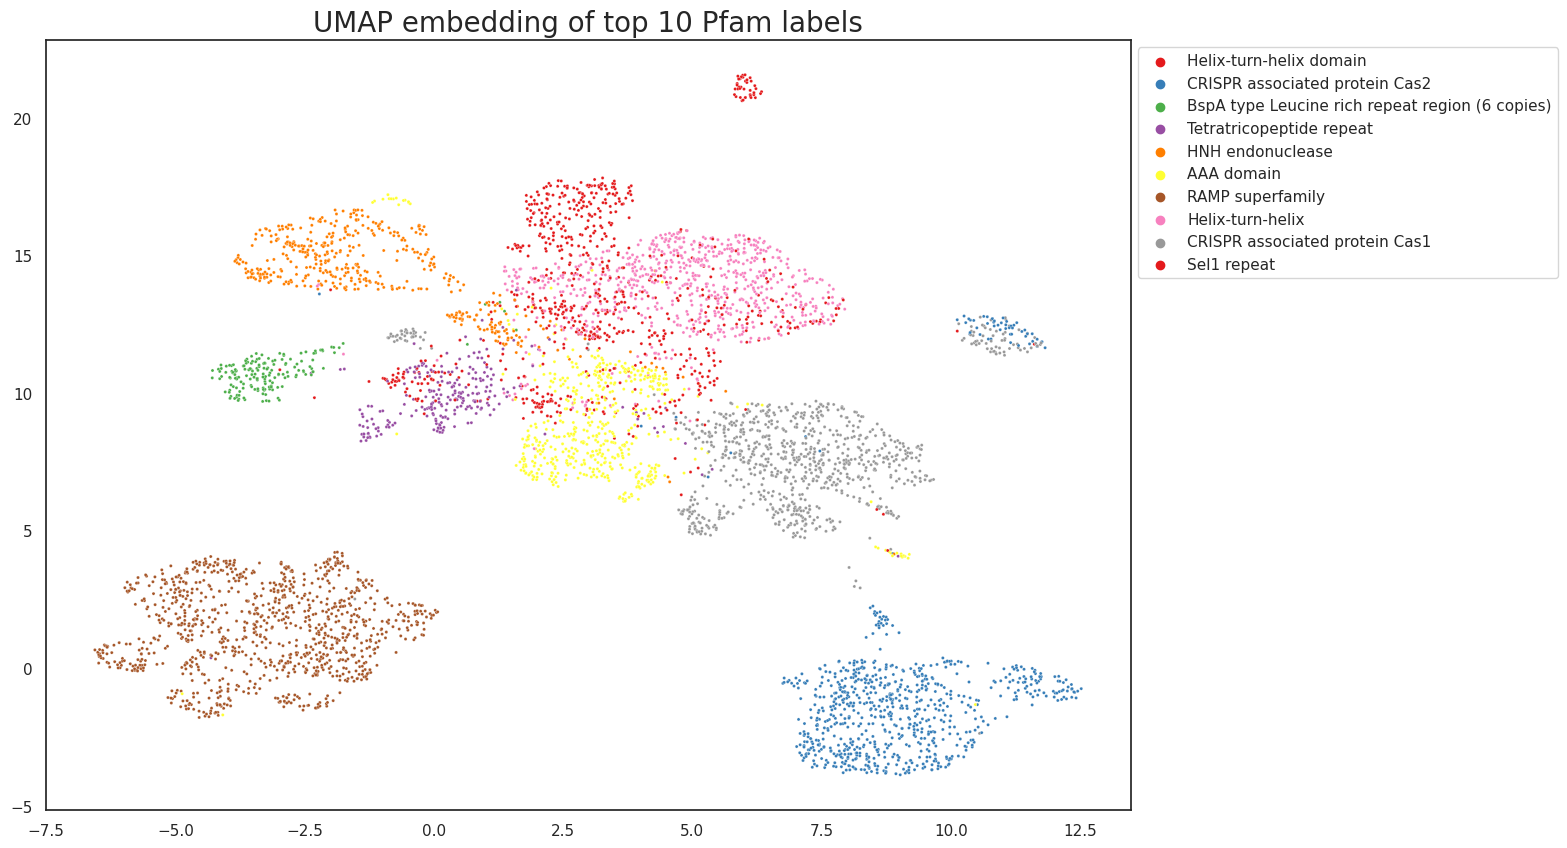

In [372]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("Set1", len(set(top_labels)))

# 绘制散点图
scatter = sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], 
                          hue=top_labels, palette=palette, s=5)

# 将图例放置到右上角，且不介入图中
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("UMAP embedding of top 10 Pfam labels",fontsize=20)

plt.show()